In [1]:
import project_path

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sqlite3 as sl
from tqdm import tqdm

from lib.utils import iterate_over
from lib.utils import load_config_and_check
from lib.inspector import Inspector

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from lib.mr import ChangeQubitOrder
config = load_config_and_check("../config/qmt_v09.yaml")

In [6]:
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
module_path

'/home/paltenmo/projects'

In [7]:
os.pardir

'..'

In [8]:
os.pardir

'..'

In [3]:
FAKE_SOURCE = """
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *

# SECTION
# NAME: CIRCUIT

qr_qr = QuantumRegister(9, name='qr_qr')
cr_qr = ClassicalRegister(9, name='cr_qr')
qc = QuantumCircuit(qr_qr, cr_qr, name='qc')
qc.append(SXdgGate(), qargs=[qr_qr[7]], cargs=[])
qc.append(ECRGate(), qargs=[qr_qr[2], qr_qr[6]], cargs=[])
qc.append(iSwapGate(), qargs=[qr_qr[5], qr_qr[4]], cargs=[])

# SECTION
# NAME: OPTIMIZATION_PASSES

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
passmanager = PassManager()
qc = passmanager.run(qc)

# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=0)

# SECTION
# NAME: MEASUREMENT

qc.measure(qr_qr, cr_qr)

# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_213141889afb4ac19d274fe469f89af0 = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=backend_213141889afb4ac19d274fe469f89af0, shots=3919).result().get_counts(qc)
RESULT = counts
"""

In [4]:
mr = ChangeQubitOrder("prova", code_of_source=FAKE_SOURCE, metamorphic_strategies_config=config["metamorphic_strategies"])

TypeError: Can't instantiate abstract class ChangeQubitOrder with abstract methods check_output_relationship

## Separable Circuits

In [10]:
circuit_code = """qr_1 = QuantumRegister(3, name='qr_1')
cr_1 = ClassicalRegister(3, name='cr_1')
qc_1 = QuantumCircuit(qr_1, cr_1, name='qc_1')
qc_1.append(SdgGate(), qargs=[qr_1[0]], cargs=[])
qc_1.append(XGate(), qargs=[qr_1[0]], cargs=[])
qc_1.append(RZZGate(0.4429181854627117), qargs=[qr_1[1], qr_1[0]], cargs=[])
qc_1.append(RYYGate(2.2725577430206263), qargs=[qr_1[0], qr_1[1]], cargs=[])
qc_1.append(TGate(), qargs=[qr_1[0]], cargs=[])
qc_1.append(XGate(), qargs=[qr_1[2]], cargs=[])"""

circuit_name = "qc_1"
register_name = "qr_1"

[0]
[0]
[1, 0]
add to the graph
[0, 1]
add to the graph
[0]
[2]


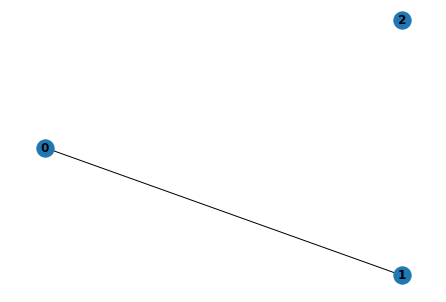

In [19]:
import re
import networkx as nx
from itertools import combinations

lines = circuit_code.split("\n")
connections = []
circuit_related_lines = [
    line for line in lines if f"{circuit_name}." in line]
qubit_interaction_graph = nx.Graph()
for line in circuit_related_lines:
    regex = f"{register_name}\[(\d+)\]"
    qubits_involved = re.findall(regex, line)
    qubits_involved = [int(q) for q in qubits_involved]
    if qubits_involved:
        # print(qubits_involved)
        
        for q in qubits_involved:
            qubit_interaction_graph.add_node(q)
        
        if len(qubits_involved) > 1:
            # consider it as edge
            print("add to the graph")
            new_edges = combinations(qubits_involved, 2)
            qubit_interaction_graph.add_edges_from(new_edges)
            
nx.draw_shell(
    qubit_interaction_graph, with_labels=True, font_weight='bold')    

In [26]:
sub_graphs = nx.connected_components(qubit_interaction_graph)
connected_components_set = set([frozenset(g) for g in sub_graphs])
connected_components_set

{frozenset({0, 1}), frozenset({2})}

In [27]:
expected = {frozenset({0, 1}), frozenset({2})}
expected

{frozenset({0, 1}), frozenset({2})}

In [28]:
assert connected_components_set == expected

In [12]:
re.findall(r"qr_1\[(\d+)\]", circuit_code)

['0', '0', '1', '0', '0', '1', '0', '2']

In [32]:
for x in range(1, 2):
    print(x)

1


# Derive separated circuits

In [5]:
code_of_source = """

# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *

# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(9, name='qr')
cr = ClassicalRegister(9, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(CU3Gate(3.9641736341624023,6.167666341622349,4.176789578690695), qargs=[qr[8], qr[0]], cargs=[])
qc.append(U3Gate(1.5736539900156161,2.6969488851398467,4.556283845054034), qargs=[qr[7]], cargs=[])
qc.append(CXGate(), qargs=[qr[1], qr[4]], cargs=[])
qc.append(RZGate(4.120878090041712), qargs=[qr[6]], cargs=[])
qc.append(RCCXGate(), qargs=[qr[7], qr[3], qr[6]], cargs=[])
qc.append(CZGate(), qargs=[qr[6], qr[5]], cargs=[])
qc.append(DCXGate(), qargs=[qr[3], qr[7]], cargs=[])
qc.append(ZGate(), qargs=[qr[3]], cargs=[])
qc.append(ZGate(), qargs=[qr[6]], cargs=[])
qc.append(TGate(), qargs=[qr[8]], cargs=[])
qc.append(RZGate(4.7982408464889215), qargs=[qr[6]], cargs=[])
qc.append(CU1Gate(5.872199665531033), qargs=[qr[7], qr[0]], cargs=[])
qc.append(SGate(), qargs=[qr[0]], cargs=[])
qc.append(CZGate(), qargs=[qr[7], qr[8]], cargs=[])
qc.append(CRZGate(3.8424030831409595), qargs=[qr[7], qr[2]], cargs=[])
qc.append(ZGate(), qargs=[qr[4]], cargs=[])
qc.append(RXXGate(5.507020553946652), qargs=[qr[6], qr[8]], cargs=[])
qc.append(CU1Gate(0.8208487059024755), qargs=[qr[0], qr[3]], cargs=[])

# SECTION
# NAME: OPTIMIZATION_PASSES

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
passmanager = PassManager()
qc = passmanager.run(qc)

# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=1, coupling_map=None)

# SECTION
# NAME: MEASUREMENT

qc.measure(qr, cr)

# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_80b3bd324dc044d8b7ff883af0ed64d0 = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=backend_80b3bd324dc044d8b7ff883af0ed64d0, shots=3919).result().get_counts(qc)
RESULT = counts"""

In [6]:
from lib.mr import RunIndependentPartitions
from lib.mr import AddUnusedRegister

In [7]:
config = load_config_and_check("../config/qmt_v09.yaml")

In [25]:
transf = AddUnusedRegister(
    name="AddUnusedRegister",
    metamorphic_strategies_config=config["metamorphic_strategies"],
    detectors_config=config["detectors"]        
)
out = transf.derive(code_of_source)
print(out)

# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(9, name='qr')
cr = ClassicalRegister(9, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(CU3Gate(3.9641736341624023, 6.167666341622349, 4.176789578690695), qargs=[qr[8], qr[0]], cargs=[])
qc.append(U3Gate(1.5736539900156161, 2.6969488851398467, 4.556283845054034), qargs=[qr[7]], cargs=[])
qc.append(CXGate(), qargs=[qr[1], qr[4]], cargs=[])
qc.append(RZGate(4.120878090041712), qargs=[qr[6]], cargs=[])
qc.append(RCCXGate(), qargs=[qr[7], qr[3], qr[6]], cargs=[])
qc.append(CZGate(), qargs=[qr[6], qr[5]], cargs=[])
qc.append(DCXGate(), qargs=[qr[3], qr[7]], cargs=[])
qc.append(ZGate(), qargs=[qr[3]], cargs=[])
qc.append(ZGate(), qargs=[qr[6]], cargs=[])
qc.append(TGate(), qargs=[qr[8]], cargs=[])
qc.append(RZGate(4.7982408464889215), qargs=[qr[6]], cargs=[])
qc.append(CU

In [31]:
transf = RunIndependentPartitions(
    name="RunIndependentPartitions",
    metamorphic_strategies_config=config["metamorphic_strategies"],
    detectors_config=config["detectors"]        
)
out = transf.derive(code_of_source)
print(out)

{'name': 'qc', 'quantum_register': 'qr', 'classical_register': 'cr', 'size': 9}
{frozenset({1, 4}), frozenset({0, 2, 3, 5, 6, 7, 8})}
[0 1]
clusters_of_this_partition [frozenset({1, 4})]
0 partition) qubits_of_this_partition: [1, 4]
clusters_of_this_partition [frozenset({0, 2, 3, 5, 6, 7, 8})]
1 partition) qubits_of_this_partition: [0, 2, 3, 5, 6, 7, 8]
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
# SECTION
# NAME: CIRCUIT

qr_1 = QuantumRegister(2, name='qr_1')
cr_1 = ClassicalRegister(2, name='cr_1')
qc_1 = QuantumCircuit(qr_1, cr_1, name='qc_1')


qc_1.append(CXGate(), qargs=[qr_1[0], qr_1[1]], cargs=[])
qc_1.append(ZGate(), qargs=[qr_1[1]], cargs=[])


qr_2 = QuantumRegister(7, name='qr_2')
cr_2 = ClassicalRegister(7, name='cr_2')
qc_2 = QuantumCircuit(qr_2, cr_2, name='qc_2')


qc_2.append(CU3Gate(3.9641736341624023, 6.167666341622349, 
    4.176789578690695), qar

In [36]:
GLOBALS = {"RESULT": 0}
exec(out, GLOBALS)
result = GLOBALS["RESULT"]

In [37]:
result

[{'00': 3919},
 {'1010000': 275, '0000000': 1714, '1110100': 292, '0100100': 1638}]

In [38]:
transf._reconstruct(result)

{'101000000': 1077725,
 '000000000': 6717166,
 '111001000': 1144348,
 '010001000': 6419322}

In [32]:
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
# SECTION
# NAME: CIRCUIT

qr_1 = QuantumRegister(2, name='qr_1')
cr_1 = ClassicalRegister(2, name='cr_1')
qc_1 = QuantumCircuit(qr_1, cr_1, name='qc_1')

qc_1.append(CXGate(), qargs=[qr_1[0], qr_1[1]], cargs=[])
qc_1.append(ZGate(), qargs=[qr_1[1]], cargs=[])


qr_2 = QuantumRegister(7, name='qr_2')
cr_2 = ClassicalRegister(7, name='cr_2')
qc_2 = QuantumCircuit(qr_2, cr_2, name='qc_2')


qc_2.append(CU3Gate(3.9641736341624023, 6.167666341622349, 
    4.176789578690695), qargs=[qr_2[6], qr_2[0]], cargs=[])
qc_2.append(U3Gate(1.5736539900156161, 2.6969488851398467, 
    4.556283845054034), qargs=[qr_2[5]], cargs=[])
qc_2.append(RZGate(4.120878090041712), qargs=[qr_2[4]], cargs=[])
qc_2.append(RCCXGate(), qargs=[qr_2[5], qr_2[2], qr_2[4]], cargs=[])
qc_2.append(CZGate(), qargs=[qr_2[4], qr_2[3]], cargs=[])
qc_2.append(DCXGate(), qargs=[qr_2[2], qr_2[5]], cargs=[])
qc_2.append(ZGate(), qargs=[qr_2[2]], cargs=[])
qc_2.append(ZGate(), qargs=[qr_2[4]], cargs=[])
qc_2.append(TGate(), qargs=[qr_2[6]], cargs=[])
qc_2.append(RZGate(4.7982408464889215), qargs=[qr_2[4]], cargs=[])
qc_2.append(CU1Gate(5.872199665531033), qargs=[qr_2[5], qr_2[0]], cargs=[])
qc_2.append(SGate(), qargs=[qr_2[0]], cargs=[])
qc_2.append(CZGate(), qargs=[qr_2[5], qr_2[6]], cargs=[])
qc_2.append(CRZGate(3.8424030831409595), qargs=[qr_2[5], qr_2[1]], cargs=[])
qc_2.append(RXXGate(5.507020553946652), qargs=[qr_2[4], qr_2[6]], cargs=[])
qc_2.append(CU1Gate(0.8208487059024755), qargs=[qr_2[0], qr_2[2]], cargs=[])
# SECTION
# NAME: OPTIMIZATION_PASSES

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
passmanager = PassManager()
qc_1 = passmanager.run(qc_1)
qc_2 = passmanager.run(qc_2)
# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc_1 = transpile(qc_1, basis_gates=None, optimization_level=1, coupling_map=None)
qc_2 = transpile(qc_2, basis_gates=None, optimization_level=1, coupling_map=None)
# SECTION
# NAME: MEASUREMENT

qc_1.measure(qr_1, cr_1)
qc_2.measure(qr_2, cr_2)
# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_80b3bd324dc044d8b7ff883af0ed64d0 = Aer.get_backend('qasm_simulator')
counts_1 = execute(qc_1, backend=backend_80b3bd324dc044d8b7ff883af0ed64d0, shots=3919).result().get_counts(qc_1)
counts_2 = execute(qc_2, backend=backend_80b3bd324dc044d8b7ff883af0ed64d0, shots=3919).result().get_counts(qc_2)
RESULT = [counts_1, counts_2]


In [33]:
transf._reconstruct(RESULT)

{'101000000': 1065968,
 '010001000': 6627029,
 '111001000': 1046373,
 '000000000': 6619191}

In [34]:
RESULT[0]

{'00': 3919}

In [35]:
RESULT[1]

{'1010000': 272, '0100100': 1691, '1110100': 267, '0000000': 1689}

In [48]:
import ast
import astpretty

def show_tree(code: str):
    tree = ast.parse(code)
    astpretty.pprint(tree)

In [49]:
show_tree("""
a = [[0, 1], [0, 2], [0, 5], [1, 0], [2, 0], [3, 4], [4, 3], [4, 5], [5, 0], [5, 4]]
""")

Module(
    body=[
        Assign(
            lineno=2,
            col_offset=0,
            end_lineno=2,
            end_col_offset=84,
            targets=[Name(lineno=2, col_offset=0, end_lineno=2, end_col_offset=1, id='a', ctx=Store())],
            value=List(
                lineno=2,
                col_offset=4,
                end_lineno=2,
                end_col_offset=84,
                elts=[
                    List(
                        lineno=2,
                        col_offset=5,
                        end_lineno=2,
                        end_col_offset=11,
                        elts=[
                            Constant(lineno=2, col_offset=6, end_lineno=2, end_col_offset=7, value=0, kind=None),
                            Constant(lineno=2, col_offset=9, end_lineno=2, end_col_offset=10, value=1, kind=None),
                        ],
                        ctx=Load(),
                    ),
                    List(
                        lineno=2,
  

In [50]:
!pip install qiskit-aer-gpu